# Data:

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

## Reading

In [2]:
# put your own address in next line
db = pd.read_excel(r'C:\Users\mcf\Desktop\Binance_BTCUSDT_d.xlsx', nrows = 472, usecols = [6]) 

print(db[1:471])
Samples = np.asarray(db[1:471])
print(Samples.shape)

    Unnamed: 6
1      57977.4
2      57991.2
3        59130
4        58202
5      57051.9
..         ...
466    7388.24
467    7316.14
468    7254.74
469       7202
470    7204.63

[470 rows x 1 columns]
(470, 1)


## Preparing Data

In [3]:
class prepare_data:
    def __init__ (self, data):
        self.old_data = data
        
    def normalize (self):
        minimum = np.amin (self.old_data, axis = 0)
        maximum = np.amax (self.old_data, axis = 0)
        normal = np.zeros(self.old_data.shape[0])
        for i in range(self.old_data.shape[0]):
            normal[i] = ((self.old_data[i] - minimum)/(maximum - minimum))
        return normal
    
    def making_matrix(self, window, size, normal):
        temp = window * (size + 1)
        self.matrix = np.zeros(temp).reshape((size + 1), window)
        for j in range(size):
            for i in range(window):
                self.matrix[j,i] = normal[j + i]
        user_matrix = self.matrix[0:size,:]
        return user_matrix
    
    def classification (self, x, binary):
        
        dif = self.matrix.shape[1] - 1

        if (binary == True):
            classification = np.zeros((self.matrix.shape[0]-1)*3).reshape((self.matrix.shape[0]-1),3)
            for i in range(self.matrix.shape[0]-1):
                if (self.matrix[i,dif] < self.matrix[i+1,dif] - x):
                    classification [i,0] = 1
                    classification [i,1], classification [i,2] = 0,0
                    
                elif (self.matrix[i+1,dif] - x <= self.matrix[i,dif] and self.matrix[i,dif] <= self.matrix[i+1,dif] + x):
                    classification [i,1] = 1
                    classification [i,0], classification [i,2] = 0,0

                elif (self.matrix[i,dif] > self.matrix[i+1,dif] + x):
                    classification [i,2] = 1
                    classification [i,1], classification [i,0] = 0,0
        else:
            classification = np.zeros((self.matrix.shape[0] - 1))

            for i in range(self.matrix.shape[0] - 1):
                if (self.matrix[i,dif] < self.matrix[i+1,dif] - x):
                    classification[i]=1
                elif (self.matrix[i+1,dif] - x <= self.matrix[i,dif] and self.matrix[i,dif] <= self.matrix[i+1,dif] + x):
                    classification[i]=2
                elif (self.matrix[i,dif] > self.matrix[i+1,dif] + x):
                    classification[i]=3
                    
        return classification
    
    def regression (self):
        regression = np.zeros((self.matrix.shape[0] - 1))
        dif = self.matrix.shape[1] - 1
        for i in range (self.matrix.shape[0]-1):
            regression [i] = self.matrix[i+1, dif]
        return regression
        

### Making an Object

In [4]:
new  = prepare_data(Samples)

### Now, you can use it:

In [5]:
nom = new.normalize()
mat = new.making_matrix (70, 400, nom)
print(mat.shape)
# for binary classification put True in second third argument of 'classificatio' (below) and for non-binary put False
cls = new.classification( 0.003, True)
print(cls.shape)
reg = new.regression()
# dimension reduction is not necessary
pca = PCA(n_components=2)
matrix = pca.fit_transform(mat)

(400, 70)
(400, 3)


In [6]:
import keras
from sklearn_som.som import SOM
from math import sqrt
from math import exp

In [8]:
def SOM_ME (train, output, epoch):
    weights = np.random.randint(0,100,output*train.shape[0]).reshape(train.shape[0], output)/100
    
    initial_weights = np.zeros(output*train.shape[0]).reshape(train.shape[0], output)
    initial_weights [:,:] = weights[:,:]

    clusters = np.zeros(train.shape[1])
    for t in range (epoch):
        for i in range (train.shape[1]):
            winner_index = winner (train[:,i], weights)
            weights = new_weights (weights, winner_index, t, train, epoch)
            #print(weights)
            clusters[i] = winner_index
    #distance = elbow_method(train, clusters, output)
    return clusters #, weights, initial_weights

In [9]:
def new_weights (out_wght, winInx, t, train, epoch):
    result = out_wght
    result[:,:] = 0.0
    neighborhood = exp(-t/epoch)
    Learning_rate = exp(-t/epoch)
    #Influence_rate = exp(-distance/2neighborhood**2)
    for i in range (result.shape[1]):
        for j in range (result.shape[0]):
            result[j,i] = out_wght[j,i] + (Learning_rate*exp(-abs(i-winInx)**2/(2*(neighborhood**2)))
                                      *(train[j,i]-out_wght[j,i]))
    return result

In [10]:
def winner (sample_row, out_wght):
    
    result = np.zeros(out_wght.shape[1])
    
    for i in range (result.shape[0]):
        result[i] = elucidean_distance(sample_row, out_wght[:,i])
    
    return np.argmin(result)

In [11]:
def elucidean_distance (row1, row2):
    size = row1.shape[0]
    result = 0.0
    for i in range (size):
        result += (row1[i]-row2[i])**2
    result = sqrt(result)
    
    return result

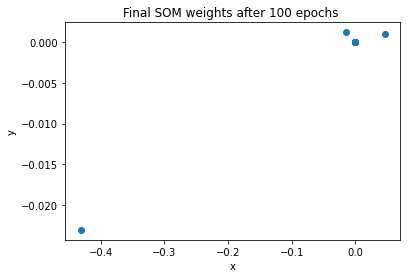

In [128]:
import matplotlib.pyplot as plt
plt.scatter (weights[0,:], weights[1,:])
plt.xlabel ('x')
plt.ylabel ('y')
plt.title ('Final SOM weights after 100 epochs ')
plt.show() 

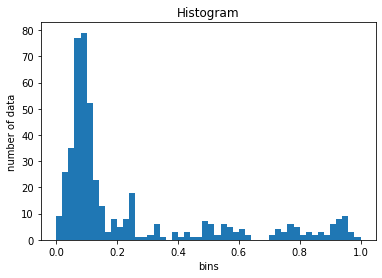

In [42]:
import matplotlib.pyplot as plt

plt.hist(nom.transpose(), bins = 50)
plt.xlabel ('bins')
plt.ylabel ('number of data')
plt.title ('Histogram')
plt.show() 


In [12]:
def elbow_method (train, cluster, k):
    result = np.zeros(k)
    temp = 0.0
    final = 0.0
    for i in range(k):
        for j in range (train.shape[1]):
            if (cluster[j]==i):
                for w in range (train.shape[1]):
                    if (cluster[w]==i):
                        temp = elucidean_distance(train[:,j],train[:,w])
                        if (temp > result[i]):
                            result[i] = temp
    final = np.amax(result)
    return final

In [13]:
def random_centers (k, train):
    size = k*train.shape[0]
    random = np.random.randint(0,(train.shape[1]-1),k)
    result = np.zeros(train.shape[0]*k).reshape(train.shape[0],k)
    
    for i in range (k):
        result[:,i] = train[:,random[i]]
    
    return result

In [14]:
def changing_centers (cluster, train, k_val):
    #print(cluster)
    new_value = np.zeros(train.shape[0]*k_val.shape[1]).reshape(train.shape[0],k_val.shape[1])
    count = np.ones(k_val.shape[1])
    for i in range (k_val.shape[1]):
        for j in range(train.shape[1]):
            if (cluster[j] == i):
                new_value[:,i] += train[:,j]
                count[i] += 1
        new_value[:,i] = new_value[:,i]/count[i]
    
    return new_value

In [15]:
def distance_k (new, old):
    distance = np.zeros(new.shape[1])
    for i in range (new.shape[1]):
        distance[i] = elucidean_distance(new[:,i]*100, old[:,i]*100)
    return distance/100

In [16]:
def K_MEANS (k, train):
    distance = np.zeros(train.shape[1]*2).reshape(2,train.shape[1])
    which_k = np.zeros(k)
    k_val = random_centers(k, train)
    cluster = np.zeros(train.shape[1])

    count = np.zeros(k)

    while (True):
        count[:]=0

        for i in range (train.shape[1]):
            for j in range (k):
                which_k[j] = elucidean_distance(k_val[:,j], train[:,i])
            
            cluster[i] = np.argmin(which_k)
            count[np.argmin(which_k)]+=1
        new_k_val = changing_centers(cluster, train, k_val)
        #print (k_val,'\n')
        #print(new_k_val,'\n')
        continuing = distance_k(new_k_val, k_val)
        #print(continuing)
    
        if (np.all(continuing<0.001)):
            maximum_distance_per_cluster = elbow_method (train, cluster, k)
            #print('this is count:\n', count)
            return cluster # maximum_distance_per_cluster
        else:
            k_val = changing_centers (cluster, train, k_val)

In [105]:
max_dis = np.zeros(67)
for i in range (3,70):
    m = K_MEANS(i,shfl_mat[:,0:300])
    max_dis[i-3]= m
    

In [107]:
max_dis

array([2.92807992, 2.81585613, 2.45115679, 2.45115679, 2.45115679,
       1.84748475, 2.45115679, 2.45115679, 2.20354588, 2.20354588,
       2.20354588, 1.34154686, 1.45622291, 1.34154686, 2.20354588,
       1.34154686, 2.20354588, 1.34154686, 2.20354588, 1.34154686,
       1.34154686, 1.34154686, 1.34154686, 1.34154686, 1.34154686,
       2.20354588, 2.20354588, 1.34154686, 1.34154686, 1.34154686,
       1.34154686, 1.34154686, 1.34154686, 1.34154686, 1.34154686,
       1.34154686, 1.34154686, 1.34154686, 1.34154686, 1.34154686,
       1.34154686, 1.34154686, 1.34154686, 1.34154686, 1.34154686,
       1.34154686, 1.34154686, 1.34154686, 1.34154686, 1.34154686,
       1.34154686, 1.34154686, 1.34154686, 1.34154686, 1.34154686,
       1.34154686, 1.34154686, 1.34154686, 1.34154686, 1.34154686,
       1.34154686, 1.34154686, 1.34154686, 1.34154686, 1.34154686,
       1.34154686, 1.34154686])

Text(0.5, 1.0, 'Elbow method')

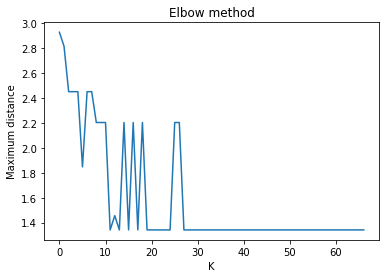

In [109]:
plt.plot (max_dis)
plt.xlabel ('K')
plt.ylabel ('Maximum distance')
plt.title ('Elbow method')

In [17]:

def Mean_Var(cluster, train):
    cl = np.zeros(train.shape[1])
    cl[:] = cluster[:]+1000
    k = 0
    for i in range (train.shape[1]):
        tem = cluster[i]
        t = np.where(cluster == tem)
        index = t[0]
        
        if (cl[i] > 1000):
            for j in (index):
                cl[j] = k
            k += 1
    
    Mean = np.zeros(train.shape[0]*k).reshape(train.shape[0],k)
    vari = np.zeros(k)
    count = 0.0
    for i in range (k):
        
        idk = np.where(cl == i)
        ind = idk[0]
        for j in (ind):
            Mean[:,i] += train[:,i]
            count += 1
        Mean[:,i] /= count
        
        for k in (ind):
            vari[i] += (elucidean_distance(Mean[:,i] , train[:,k]))**2
        vari[i] = sqrt(vari[i]/count)

    return Mean,vari,k

In [18]:

def RBF (train, test, mean, variance, ctrain, ctest, k):
    fit = np.zeros(100)
    weight = np.random.randint(-100,100,k*3).reshape(3,k)/100
    correct = 0
    for j in range (1000):
        for i in range (train.shape[1]):
            kernel_output = kernel(train[:,i], mean, variance, k)
            weight, p = output_layer(kernel_output, ctrain[:,i], weight)
        
    for i in range(test.shape[1]):
        kernel_tout = kernel(test[:,i], mean, variance, k)
        pred = prediction(kernel_tout, ctest[:,i], weight)
        fit[i] = pred
        if pred == np.argmax(ctest[:,i]):
            correct += 1
    correct = correct/100
    return correct

In [19]:
def prediction (kernel_output, class_values, weight):
    result = np.zeros(3).reshape(3,1)
    kernelT = np.zeros(kernel_output.shape[0]).reshape(kernel_output.shape[0],1)
    for z in range (kernel_output.shape[0]):
        kernelT[z,0] = kernel_output[z]
        
    for i in range (weight.shape[0]):
        result[i,0] = np.matmul(weight[i,:],kernelT)
        result[i,0] = 1/(1+exp(-result[i,0]))

    #print(result)
    size = weight.shape
    pred = np.argmax(result)
    #print(pred)
    return pred

In [20]:
def output_layer (kernel_output, class_values, weight):
    result = np.zeros(3).reshape(3,1)
    kernelT = np.zeros(kernel_output.shape[0]).reshape(kernel_output.shape[0],1)
    for z in range (kernel_output.shape[0]):
        kernelT[z,0] = kernel_output[z]
        
    for i in range (weight.shape[0]):
        result[i,0] = np.matmul(weight[i,:],kernelT)
        result[i,0] = 1/(1+exp(-result[i,0]))
    error = class_values-result
    
    size = weight.shape
    
    new_weights = np.zeros(size[0]*size[1]).reshape(size[0],size[1])
    pred = np.argmax(result)
    #print(pred)
    if (np.all(abs(error) > 0.5)):
        for i in range (3):
            for j in range(kernel_output.shape[0]):
                new_weights[i,j] = weight[i,j] + 0.01*error[i,0]*kernel_output[j]
        return new_weights, pred
    else: return weight, pred

In [21]:
def kernel (sample, mean, variance, k):
    result = np.zeros(k)
    
    for i in range (mean.shape[1]):
        result[i] = exp(-(elucidean_distance(sample, mean[:,i]))/(2*variance[i]))
    return result
            

In [22]:

def shuffle (array, classification, window):
        import random as rand
        temp = np.zeros(window).reshape(window,1)
        for i in range(0,400):
                random_val1 = rand.randint(0,399)
                random_val2 = rand.randint(0,399)
                temp = array[:,random_val1]
                array[:,random_val1]=array[:,random_val2]
                array[:,random_val2]=temp
                temp = classification [:,random_val1]
                classification[:,random_val1] = classification [:,random_val2]
                classification[:,random_val2] = temp
        return array, classification 

In [28]:
acc = np.zeros (60). reshape (2,30)
for i in range (30):
    shfl_mat,shfl_cls = shuffle (matrix.transpose(),cls.transpose(), 2)
    clus, weights, initial = SOM_ME(shfl_mat[:,0:300], 300 , 100)
    Kmeancluster = K_MEANS (30, shfl_mat[:,0:300])
    mean1 , var1 ,k1 = Mean_Var(clus, shfl_mat[:,0:300])
    mean2 , var2, k2 = Mean_Var(Kmeancluster, shfl_mat[:,0:300])
    
    acc [0,i] = RBF (shfl_mat[:,0:300], shfl_mat[:,300:400], mean1, var1, shfl_cls[:,0:300], shfl_cls[:,300:400], k1)
    acc [1,i] = RBF (shfl_mat[:,0:300], shfl_mat[:,300:400], mean2, var2, shfl_cls[:,0:300], shfl_cls[:,300:400], k2)

In [33]:
num = np.arange(30)
num

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [31]:
acc

array([[0.38, 0.52, 0.5 , 0.31, 0.48, 0.62, 0.42, 0.42, 0.55, 0.64, 0.42,
        0.41, 0.49, 0.38, 0.37, 0.58, 0.49, 0.41, 0.43, 0.84, 0.45, 0.46,
        0.51, 0.35, 0.3 , 0.34, 0.41, 0.3 , 0.41, 0.5 ],
       [0.54, 0.55, 0.32, 0.51, 0.51, 0.48, 0.42, 0.4 , 0.49, 0.49, 0.42,
        0.42, 0.49, 0.32, 0.66, 0.4 , 0.51, 0.3 , 0.43, 0.58, 0.43, 0.42,
        0.33, 0.45, 0.55, 0.51, 0.44, 0.53, 0.41, 0.5 ]])

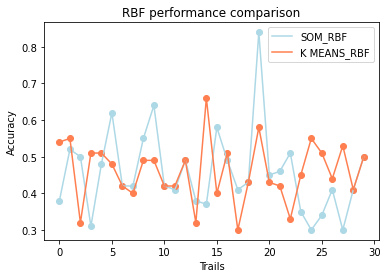

In [41]:
import matplotlib.pyplot as plt
plt.scatter(num[:],acc[0,:], color = 'lightblue')
plt.plot (acc[0,:], color = 'lightblue', label = 'SOM_RBF')
plt.plot (acc[1,:], color = 'coral', label = 'K MEANS_RBF')
plt.scatter(num[:], acc[1,:], color = 'coral')
plt.xlabel('Trails')
plt.ylabel('Accuracy')
plt.title('RBF performance comparison')
plt.legend()
plt.show()
